# **Predicting Wine Quality Through Classification and Regression**
#### DSCI 100 Winter T2 Group 006-042

## Introduction:

Consumer selection on wine has been heavily dependent on quality certifications for purchasing decisions and producers have been doing the same for pricing (Cortez et al., 2009). The certification for wine quality is a tedious process, requiring wine experts (connoisseurs) to sample the taste and smell of the wine to determine its quality (Cortez et al., 2009). However, there are biases when conducting these sensory taste tests due to personal preferences of the experts and the complex nature of the human taste bud (Smith and Margolskee, 2001).

We would like to know whether it is possible to obtain an accurate model to predict wine quality based on its chemical properties, ultimately replacing human sensory evaluators.
For this purpose, we use the KNN classification model over a data set containing the chemical properties and quality of 1599 different red wines.

The data set is collected in 2009 by Cortez et al. and has the following 12 variables:

#### Attribute (units):
- Fixed acidity ($g/dm^3$)
- Volatile acidity ($g/dm^3$)
- Citric acid ($g/dm^3$)
- Residual sugar ($g/dm^3$)
- Chlorides ($g/dm^3$)
- Free sulfur dioxide ($mg/dm^3$)
- Total sulfur dioxide ($mg/dm^3$)
- Density ($g/cm^3$)
- pH
- Sulphates ($g/dm^3$)
- Alcohol ($vol.\%$)
- Quality (from 0 to 10)

The quality variable is determined from the range 0-10 based on the evaluations of 3 human assessors.

We will not be using all the given variables for quality prediction, as we find some of the variables correlated, and some not related to the quality. The way we choose the variables is 

## Expected Outcomes and Significance:

The impact of these findings may help improve the wine industry. In recent years, this industry is growing and thus there is an increased interest in investing in more innovative techniques that may enhance wine production as well as its selling. Our work aims to integrate subjective rankings to objective measures so that people can extrapolate these findings and make better quality wines. These variables are able to be controlled and manipulated during production. Thus, our findings may be used by oenologists to improve their wine production.

Future questions that may arise include those concerned over what other potential factors may influence the quality of wine or whether the interaction between variables has a greater impact than considered singularly. Further assessment may attempt to discover relationships between variables that together produce a stronger prediction of wine quality. This analysis may also raise the question of whether subjective experience or objective measures matter most. It is possible that personal and sensory experiences play a larger role in shaping wine quality rankings. Therefore, further analysis may explore these subjective factors.


## Methods and Results:

#### Preliminary Exploratory Data Analysis

To begin, we must load necessary packages and libraries into R.

In [2]:
# package installations and loading libraries
install.packages("themis")
library(tidyverse)
library(tidymodels)
library(reshape2)
library(gridExtra)
library(recipes) 
library(themis) 

also installing the dependencies ‘fastmatch’, ‘ParamHelpers’, ‘BBmisc’, ‘checkmate’, ‘parallelMap’, ‘XML’, ‘hardhat’, ‘ipred’, ‘mlr’, ‘doParallel’, ‘FNN’, ‘recipes’, ‘generics’, ‘RANN’, ‘ROSE’, ‘unbalanced’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built unde

We must now read our data set into R from the external web source.

In [16]:
# downloading and reading the red wine quality dataset into R
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
destination <- "data/red_wine_quality.csv"
download.file(url, destination)

data <- read.csv(destination, head = TRUE, sep = ";")
glimpse(data)

Rows: 1,599
Columns: 12
$ fixed.acidity        <dbl> 7.4, 7.8, 7.8, 11.2, 7.4, 7.4, 7.9, 7.3, 7.8, 7.…
$ volatile.acidity     <dbl> 0.700, 0.880, 0.760, 0.280, 0.700, 0.660, 0.600,…
$ citric.acid          <dbl> 0.00, 0.00, 0.04, 0.56, 0.00, 0.00, 0.06, 0.00, …
$ residual.sugar       <dbl> 1.9, 2.6, 2.3, 1.9, 1.9, 1.8, 1.6, 1.2, 2.0, 6.1…
$ chlorides            <dbl> 0.076, 0.098, 0.092, 0.075, 0.076, 0.075, 0.069,…
$ free.sulfur.dioxide  <dbl> 11, 25, 15, 17, 11, 13, 15, 15, 9, 17, 15, 17, 1…
$ total.sulfur.dioxide <dbl> 34, 67, 54, 60, 34, 40, 59, 21, 18, 102, 65, 102…
$ density              <dbl> 0.9978, 0.9968, 0.9970, 0.9980, 0.9978, 0.9978, …
$ pH                   <dbl> 3.51, 3.20, 3.26, 3.16, 3.51, 3.51, 3.30, 3.39, …
$ sulphates            <dbl> 0.56, 0.68, 0.65, 0.58, 0.56, 0.56, 0.46, 0.47, …
$ alcohol              <dbl> 9.4, 9.8, 9.8, 9.8, 9.4, 9.4, 9.4, 10.0, 9.5, 10…
$ quality              <int> 5, 5, 5, 6, 5, 5, 5, 7, 7, 5, 5, 5, 5, 5, 5, 5, …


We chose to replace the dots spearating words in our variable names with underscores to make the names more legible and less cluttered. We chose to exclude values equal to 0 in our analysis so that there would be no interference in our analysis later down the road.

In [45]:
# cleaning and wrangling the dataset
colnames(data) <- gsub("\\.", "_", names(data))
colnames(data)[colnames(data) %in% c("free_sulfur_dioxide", "total_sulfur_dioxide")] <- c("free_so2", "total_so2")

clean_data <- data %>%
              mutate(quality = as_factor(quality)) %>%
              filter(citric_acid > 0)

head(clean_data)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2,total_so2,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
2,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
3,7.9,0.60,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,5
4,7.8,0.58,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,7
5,7.5,0.50,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5
6,6.7,0.58,0.08,1.8,0.097,15,65,0.9959,3.28,0.54,9.2,5


We split the data into training and test sets for analysis down the road.

In [46]:
# splitting data into a training and testing dataset
set.seed(7)
clean_data_split <- initial_split(clean_data, prop = 0.6, strata = quality)
train_data <- training(clean_data_split)
test_data <- testing(clean_data_split) 
glimpse(train_data)

Rows: 881
Columns: 12
$ fixed_acidity    <dbl> 11.2, 7.8, 6.7, 7.9, 8.5, 6.9, 6.3, 7.9, 8.3, 7.3, 7…
$ volatile_acidity <dbl> 0.280, 0.580, 0.580, 0.430, 0.490, 0.400, 0.390, 0.4…
$ citric_acid      <dbl> 0.56, 0.02, 0.08, 0.21, 0.11, 0.14, 0.16, 0.21, 0.12…
$ residual_sugar   <dbl> 1.9, 2.0, 1.8, 1.6, 2.3, 2.4, 1.4, 1.6, 2.3, 5.9, 5.…
$ chlorides        <dbl> 0.075, 0.073, 0.097, 0.106, 0.084, 0.085, 0.080, 0.1…
$ free_so2         <dbl> 17, 9, 15, 10, 9, 21, 11, 10, 15, 12, 12, 8, 9, 5, 8…
$ total_so2        <dbl> 60, 18, 65, 37, 67, 40, 23, 37, 113, 87, 87, 14, 23,…
$ density          <dbl> 0.9980, 0.9968, 0.9959, 0.9966, 0.9968, 0.9968, 0.99…
$ pH               <dbl> 3.16, 3.36, 3.28, 3.17, 3.17, 3.43, 3.34, 3.17, 3.17…
$ sulphates        <dbl> 0.58, 0.57, 0.54, 0.91, 0.53, 0.63, 0.56, 0.91, 0.66…
$ alcohol          <dbl> 9.8, 9.5, 9.2, 9.5, 9.4, 9.7, 9.3, 9.5, 9.8, 10.5, 1…
$ quality          <fct> 6, 7, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 4, 5, 5, 5…


We then wanted to get a sense of our variable summary statistics to see what kind of data we are delaing with.

In [47]:
# summarizing the mean of all variables in our training dataset
train_data_mean_summary <- train_data %>%
                           mutate(quality = as.numeric(quality)) %>%
                           map_dfr(mean, na.rm = TRUE)

colnames(train_data_mean_summary) <- paste("mean", colnames(train_data_mean_summary), sep = "_")
train_data_mean_summary

mean_fixed_acidity,mean_volatile_acidity,mean_citric_acid,mean_residual_sugar,mean_chlorides,mean_free_so2,mean_total_so2,mean_density,mean_pH,mean_sulphates,mean_alcohol,mean_quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.449716,0.5086095,0.299126,2.539955,0.0889319,15.97276,48.82974,0.996793,3.292452,0.6659478,10.39353,3.667423


In [48]:
# counting the number of observations per our quality classifier
train_data_quality_summary <- train_data %>%
                              group_by(quality) %>%
                              summarize(count = n(),
                                        proportion = n() / nrow(train_data) * 100)
train_data_quality_summary

`summarise()` ungrouping output (override with `.groups` argument)



quality,count,proportion
<fct>,<int>,<dbl>
3,1,0.1135074
4,24,2.7241771
5,378,42.9057889
6,354,40.1816118
7,112,12.7128263
8,12,1.3620885


It is clear that there is a disproportiate number of wine quality classifications in our data set, with more classified in the middle quality categories and less in the more extreme categories.

In [49]:
# scaling the training data
train_data_scaled <- train_data %>%
                     mutate_at(vars(-quality, -pH),
                               ~(scale(., center = TRUE) %>% as.vector))

In [50]:
# visualizing the data
alcohol_plot <- train_data %>%
                ggplot(aes(x = quality, y = alcohol)) +
                geom_boxplot() +
                theme(text = element_text(size = 14))
volatile_acidity_plot <- train_data %>%
                      ggplot(aes(x = quality, y = volatile_acidity)) +
                      geom_boxplot() +
                      theme(text = element_text(size = 14))
sulphates_plot <- train_data %>%
                  ggplot(aes(x = quality, y = sulphates)) +
                  geom_boxplot() +
                  theme(text = element_text(size = 14))
total_so2_plot <- train_data %>%
                  ggplot(aes(x = quality, y = total_so2)) +
                  geom_boxplot() +
                  theme(text = element_text(size = 14))

train_data_quality_summary_plot <- train_data_quality_summary %>%
                                   ggplot(aes(x = quality, y = count)) +
                                   geom_bar(stat = "identity") +
                                   labs(x = "Quality", y = "Count") +
                                   theme(text = element_text(size = 14))

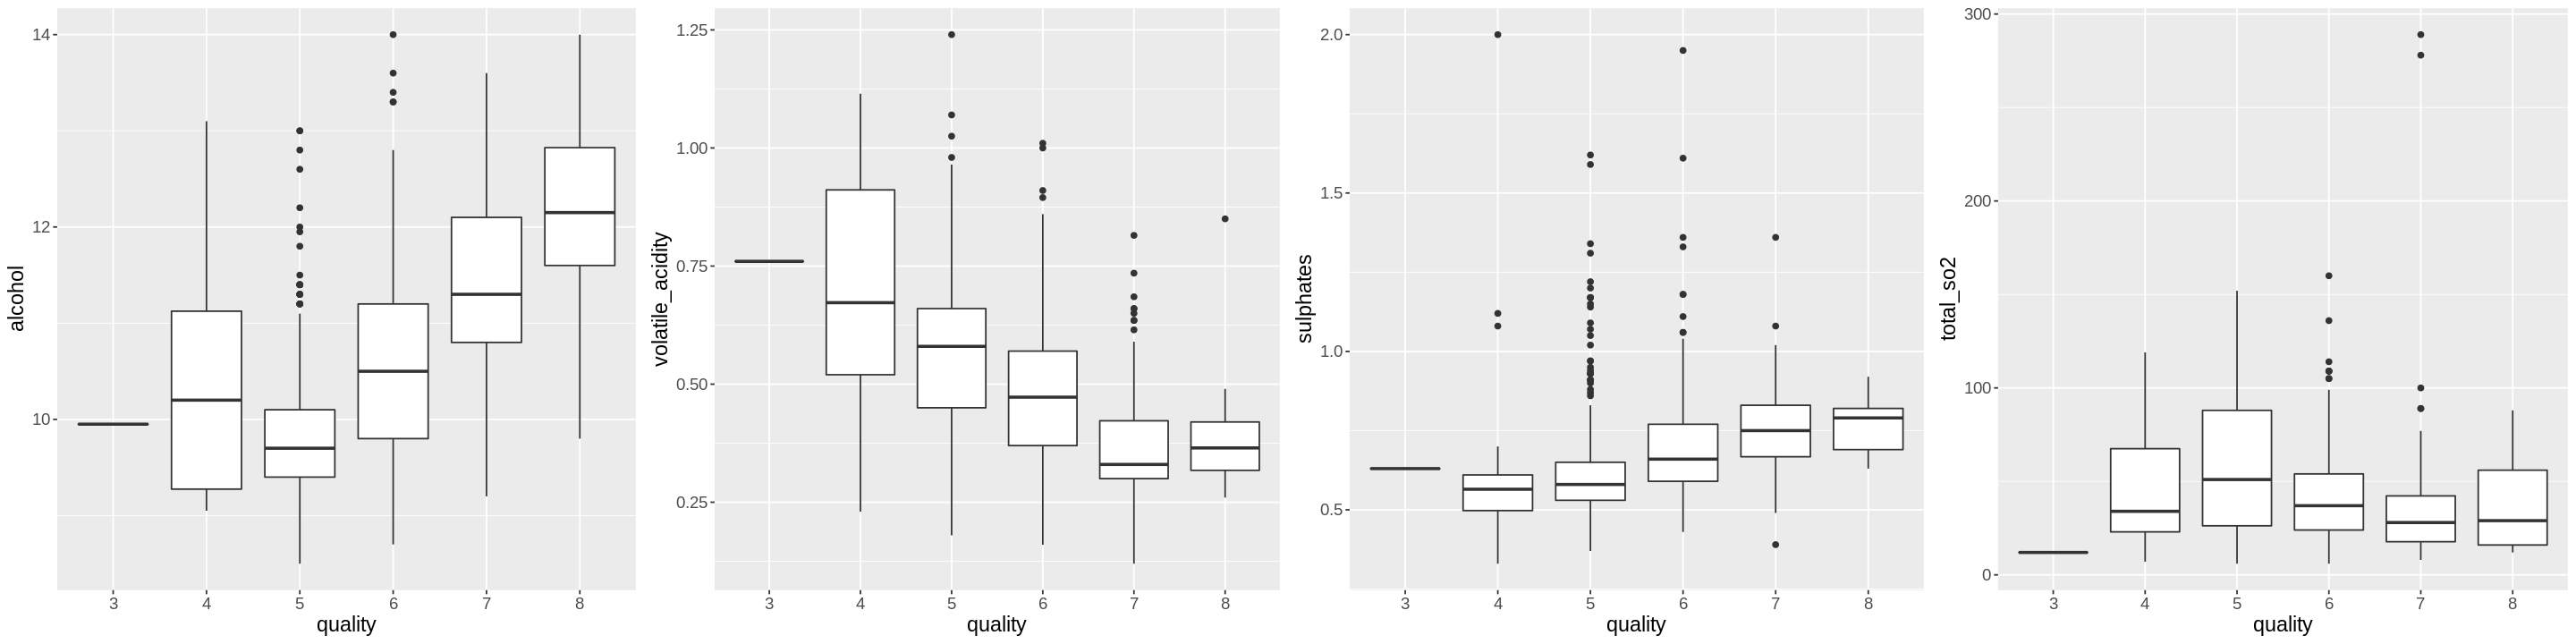

In [51]:
# boxplots for our predictor variables to visualize the trend between quality rating and amount measurement
options(repr.plot.width = 24, repr.plot.height = 6)
summary_plot <- grid.arrange(alcohol_plot,
                             volatile_acidity_plot,
                             sulphates_plot,
                             total_so2_plot,
                             nrow=1)

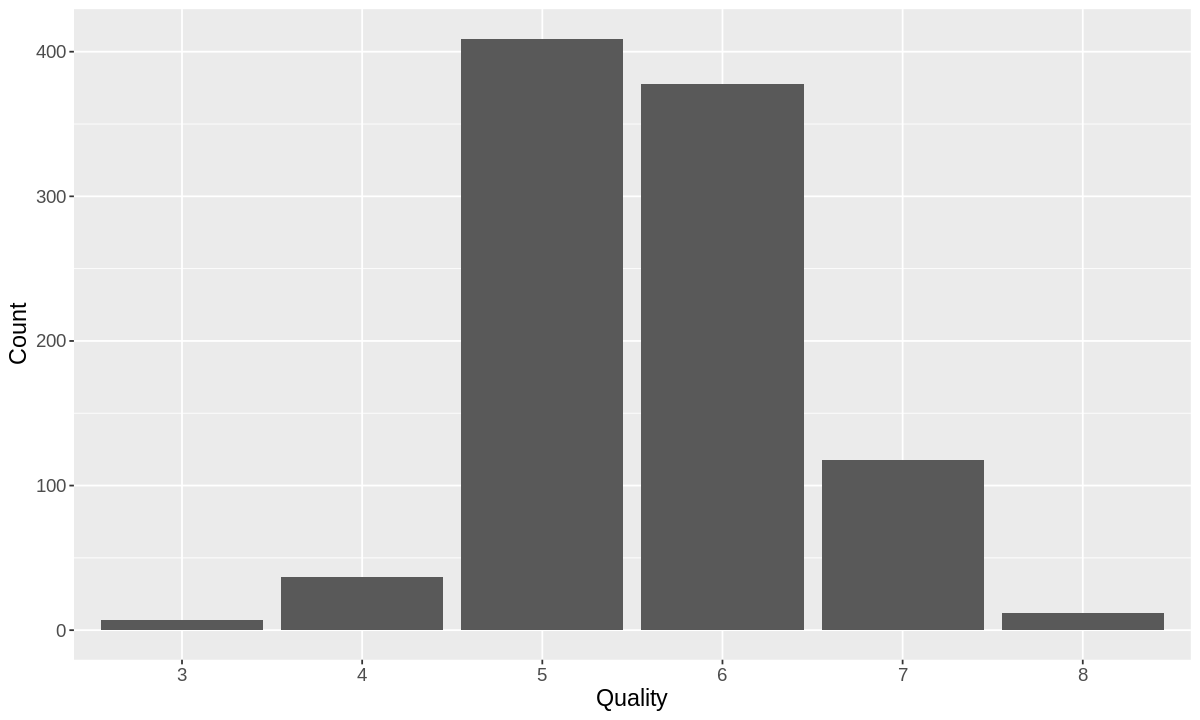

In [31]:
# count of observations per classifier plot
options(repr.plot.width = 10, options.repr.plot.height = 15)
train_data_quality_summary_plot

Counts for every observable quality in the training dataset.

#### Data Analysis

Our data analysis will be conducted using a classification model using the k-nearest-neighbours algorithm. This algorithm uses distances from data points in a data set where we know the category we are trying to predict. The distances are computed relative to a new observation in which we do not know the category for. The data points with the shortest distances away from the novel observation are used to predict the category of the new observation by a majority classifier. Meaning that the closest points vote on a class for the new observation. Depending on how many 'neighbours' we use, the accuracy may change. We must prevent overfitting the data to the noisy training data set and also underfitting our model which both reduce overall prediction accuracy. Thus, it is important we pick the appropriate k value in our model to create the best model for predicting subsequent novel observations accurately.

We begin with using predictor variable selection to find the best predictors in our model. We then tune the model with different values of k to determine the best number of neighbours for our classifier. After obtaining the best k value, we evaluate the accuracy of our model on a test set. We compare the accuracy of our model to another model containing predictor variables as suggested by the paper accompanying the data set. 

#### Predictor Selection of Our First Model

The wine dataset started with a fair amount of potential predictor variables. We first selected a subset of predictor variables from the training set to prevent irrelevant variables from negatively affecting our classifier model. Irrelevant predictors may add a random amount to the distances between observations. This would compromise the accuracy of our model. Selecting a subset of predictor variables would also help reduce computational time. 

We obtained the best predictor variables in R code using a forward selection method, as the best subset selection method would be too computationally expensive and inefficient on our large dataset. This method can be justified as we do not have a large total number of predictor variables and thus this method would not pose as high of a risk on overestimating the accuracy of one of the training models.

To begin our analysis, we created an object dataframe that excluded the quality variable we are predicting. This was the only categorical variable in our dataset so no further alterations were required.

In [52]:
set.seed(7)

# determining predictors
data_subset <- train_data
names <- colnames(data_subset %>% select(-quality))

We then created an empty tibble to store our results of each model string's accuracy, a model specification for k-nn classification, and a 5-fold cross-validation object.

In [53]:
# empty tibble to store results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# model specification
spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# 5-fold cross-validation object
data_vfold <- vfold_cv(data_subset, v = 5, strata = quality)

The total number of predictors was stored as an object to be used in creating the model formula. 

Another object was created to store the selected predictors. 

In [54]:
# storing the total number of predictors
n_total <- length(names)

# storing selected predictors
selected <- c()

Next, we generated two for loops to generate our candidate models through iterative processes. One of which increases the predictor subset size by one and another that chose the best predictor to be added in the next model string. 

We created a model string using the paste and collapse function to make a model formula for all predictors.

For each set of possible predictor combinations, a recipe was created (and standardized to prevent disturbances in the distance calculations of the k-nearest neighbours) before being passed in a workflow that tuned the classifier using 5-fold cross-validation. The recipe used a model formula to test each set of predictors. We chose the best k value by collecting the metrics of the cross-validation accuracy and selecting the k with the highest obtained accuracy value.

The best k value was added into each set of predictors. The resulting accuracies were put into the empty dataframe to compare each model string.

In [55]:
set.seed(7)

# the first for loop - for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    
# for every predictor still not added yet
accs <- list()
models <- list()

# for the second for loop - adds best predictor in the next model string
for (j in 1:length(names)) {
        
# model string for the combination of predictors
preds_new <- c(selected, names[[j]])
model_string <- paste("quality", "~", paste(preds_new, collapse="+"))
        
# recipe created from the model string
data_recipe <- recipe(as.formula(model_string), 
                data = data_subset) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

# tuning the KNN classifier with the recipe and model specification then collecting the accuracy for the best K.
acc <- workflow() %>%
        add_recipe(data_recipe) %>%
        add_model(spec) %>%
        tune_grid(resamples = data_vfold, grid = 10) %>%
        collect_metrics() %>%
        filter(.metric == "accuracy") %>%
        summarize(mx = max(mean))

acc <- acc$mx %>% unlist()
    
# adding best k to the dataframe
accs[[j]] <- acc
models[[j]] <- model_string
}
    
jstar <- which.max(unlist(accs))
    
accuracies <- accuracies %>% 
              add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    
selected <- c(selected, names[[jstar]])
    
names <- names[-jstar]
}

accuracies

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,quality ~ alcohol,0.5197869
2,quality ~ alcohol+sulphates,0.5777369
3,quality ~ alcohol+sulphates+total_so2,0.6038676
4,quality ~ alcohol+sulphates+total_so2+residual_sugar,0.6174786
5,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides,0.6230250
6,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity,0.6356094
7,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2,0.6299080
8,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2+citric_acid,0.6220242
9,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2+citric_acid+fixed_acidity,0.6255432


The table above suggests that a classifier using four predictor variables (fixed_acidity, residual_sugar, alcohol, sulphates, total_so2) would provide the best accuracy (~60% accuracy). We used these variables in the remaining analysis accordingly.

#### Should we Upsample?

We know that our data set is imbalanced from our preliminary data exploration. We wanted to see how big of an effect the imbalance would have on our data.

To test this, we upsampled the lower count variables to match those with higher counts in our recipe and proceeded with the analysis as previously done to tune our KNN model.

In [ ]:
# recipe using upsampling
recipe_upsampled <- recipe(quality ~., data = predictor_train_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(quality, over_ratio = 1)

# KNN analysis
# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, alcohol, volatile_acidity, sulphates, total_so2, chlorides, volatile_acidity))

# recipe specifying the use of all predictor variables on predicting quality
recipe <- recipe(quality ~., data = predictor_train_data) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# retraining the model with k = 39
best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 39) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
train_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(best_model) %>%
                fit(predictor_train_data)

# creates a prediction on the test data
predicted <- predict(train_fit, test_data) %>%
             bind_cols(test_data)

#### Finding the Best K value in our classifier

Using our selected predictor variables, we begin tuning our classifier. 

We tuned our K-NN classifier with the selected variables and determined the best k using cross-validation. We started by refining our training data so only the chosen predictors and predictor variables were present. Then we created a recipe using the refined training data and standardized the variables, set our model specification to k-nearest neighbours classification, and created a 5-fold cross-validation model stratified by quality. Using a workflow, we tuned the model to values of k ranging from 1-100 by 5. We collected the accuracies of the folds and plotted them over k-neighbours. As a result, there was a high and stable accuracy in the range of k values 25-75 at an average of about 0.58. 

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



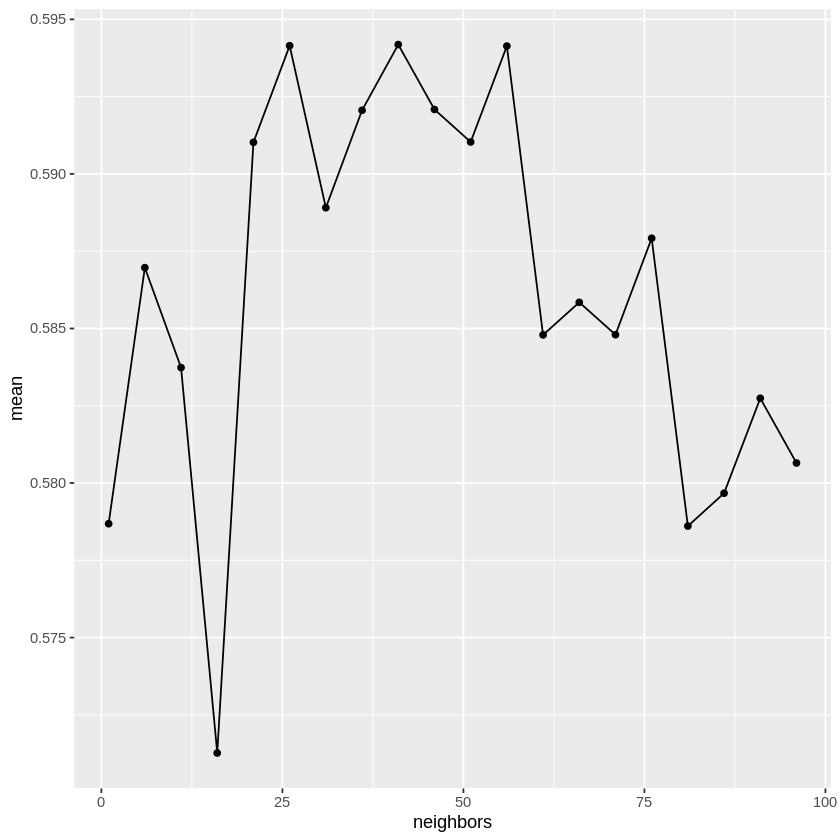

In [41]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, alcohol, volatile_acidity, sulphates, total_so2))

# recipe specifying the use of all predictor variables on predicting quality
recipe <- recipe(quality ~., data = predictor_train_data) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# tuning the model and specifying k-nn classification 
model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# creating the 5-fold cross-validation object
vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# range of k values tested
k_vals <- tibble(neighbors = seq(1,100,5))

# tuning the model in a workflow
train_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(model) %>%
                tune_grid(resamples = vfold, grid = k_vals) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

# plotting accuracies by k values
k_plot <- ggplot(train_fit, aes(x=neighbors, y=mean)) + geom_point() + geom_line()
k_plot

The code above yeilded a very variable k plot of accuracy. The best range of k values appears to be within k values of 25-75 with accuracies each about 0.58. We decided to redo the model tuning procedure using k values within the specified range above to see if we get a more stable plot and to help identify the best k within this range.

We retried tuning the model for values of k ranging from 25-75 by 2. We plotted the accuracy against k values similar to what was done previously to get a sense of the accurracy variability. We also previewed the 6 highest accuracy k values using the tail function to identify the best k.

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
45,accuracy,multiclass,0.5931107,5,0.009282647,Model11
27,accuracy,multiclass,0.5941252,5,0.010833824,Model02
25,accuracy,multiclass,0.5941577,5,0.008673268,Model01
41,accuracy,multiclass,0.5941848,5,0.007473561,Model09
47,accuracy,multiclass,0.5941957,5,0.011067949,Model12
39,accuracy,multiclass,0.5962574,5,0.009303498,Model08


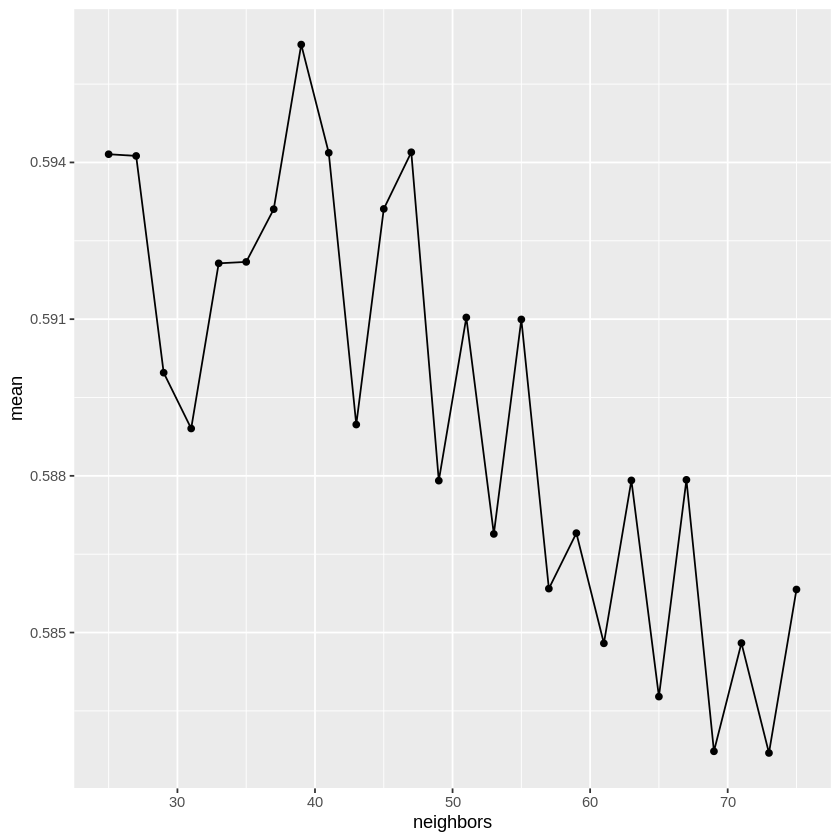

In [42]:
set.seed(7)

# new range of k values being tested
k_vals_2 <- tibble(neighbors = seq(25,75,2))

# tuning the model in a workflow
train_fit_2 <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(model) %>%
                tune_grid(resamples = vfold, grid = k_vals_2) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

k_plot_2 <- ggplot(train_fit_2, aes(x=neighbors, y=mean)) + geom_point() + geom_line()
k_plot_2

tail(train_fit_2)

After collecting the accuracies of each k and plotting it against accuracy, we found that a k value of 39 would be our best choice (accuracy of 0.596). There was a lot fo variability in accuracies in our plots but we attributed this to inherit properties of raw data. Therefore, the most stable k value was within the 30-40 range. In concordance, the k value that obtained the highest value was at 39. 

We retrained our model to a k value of 39 and evaluated our accuracy on the test data set to see how generalizable the results are to furutre observations.

In [33]:
# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, alcohol, volatile_acidity, sulphates, total_so2))

# recipe specifying the use of all predictor variables on predicting quality
recipe <- recipe(quality ~., data = predictor_train_data) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# retraining the model with k = 39
best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 39) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
train_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(best_model) %>%
                fit(predictor_train_data)

# creates a prediction on the test data
predicted <- predict(train_fit, test_data) %>%
             bind_cols(test_data)

In [35]:
# prediction accuracy of our model on the test data 
predict_accuracy <- predicted %>%
                    metrics(truth = quality, estimate = .pred_class) %>%
                    filter(.metric == "accuracy")
predict_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6065831


The obtained accuracy of our model on the test data is 0.61. This is better than the training accuracy of our best model. Thus, this model has a good evaluation accuracy and may sufficient at generalizing to future observations.

add something here to explain the rare data accuracy part

In [57]:
test_data_rare <- test_data %>% filter(quality %in% c(3,4,8))

# prediction accuracy of our model on the rare quality observations of the test data 
predict_accuracy_rare <- predict(train_fit, test_data_rare) %>%
                            bind_cols(test_data_rare) %>%
                            metrics(truth = quality, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
predict_accuracy_rare

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0


In [280]:
# generates a confusion matrix
confusion <- predicted %>%
             conf_mat(truth = quality, estimate = .pred_class)
confusion

          Truth
Prediction   3   4   5   6   7   8
         3   0   0   0   0   0   0
         4   0   0   0   0   0   0
         5   3  11 209  84   5   0
         6   0   5  63 161  59   5
         7   0   0   0  15  17   1
         8   0   0   0   0   0   0

### Visualization

Here we visualized our confusion matrix on a heat map.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



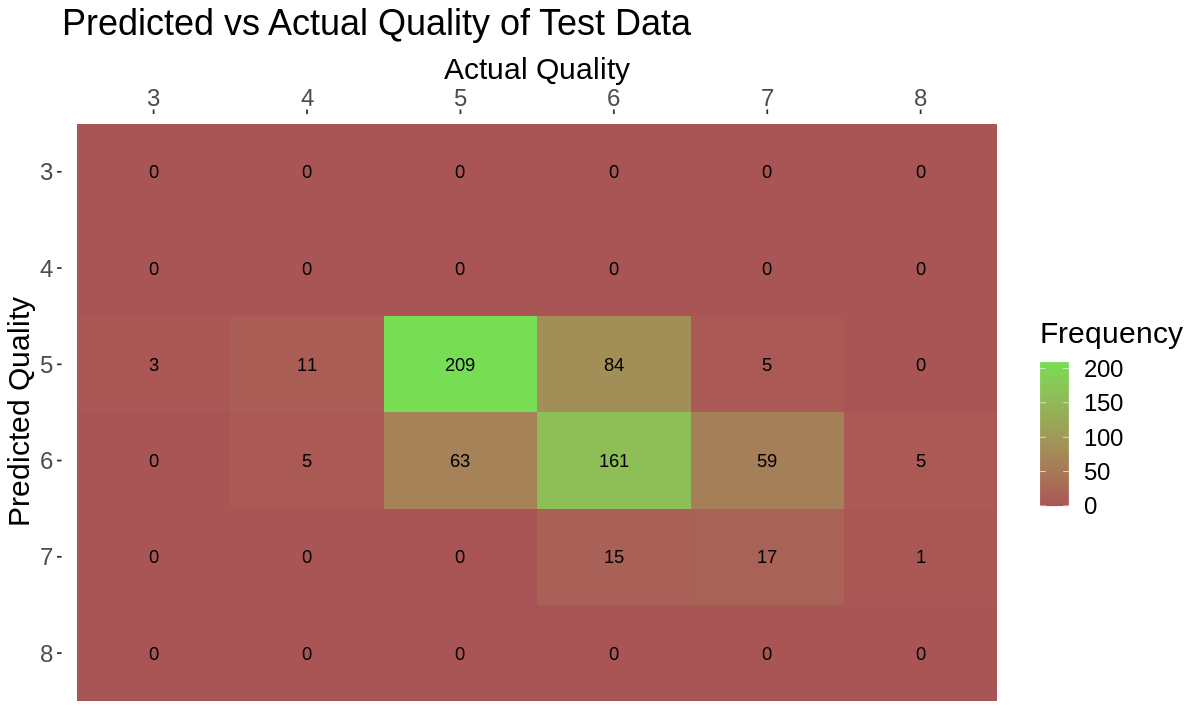

In [237]:
confusion_plot <- confusion %>%
                  autoplot(type = "heatmap") +
                  scale_x_discrete(position = "top") +
                  scale_fill_gradient(low = "#aa5555", high = "#77dd55") +
                  labs(x = "Actual Quality", y = "Predicted Quality", fill = "Frequency") +
                  theme(legend.position = "right", text = element_text(size = 18)) +
                  ggtitle("Predicted vs Actual Quality of Test Data")
confusion_plot

Using a bar plot, we visualized the proportion of correct and incorrect predictions made by our model.

In [402]:
# converts the confusion matrix into a dataframe
confusion_df <- data.frame(confusion$table)
colnames(confusion_df)[which(names(confusion_df) == "Truth")] <- "quality"

# summarizes the number of right and wrong predictions
prediction_summary <- confusion_df %>%
                      group_by(quality) %>%
                      mutate(total_count = sum(Freq),
                             right = Freq,
                             wrong = total_count - Freq) %>%
                      filter(Prediction == quality) %>%
                      select(-Prediction, -Freq)
prediction_summary

quality,total_count,right,wrong
<fct>,<int>,<int>,<int>
3,3,0,3
4,16,0,16
5,272,209,63
6,260,161,99
7,81,17,64
8,6,0,6


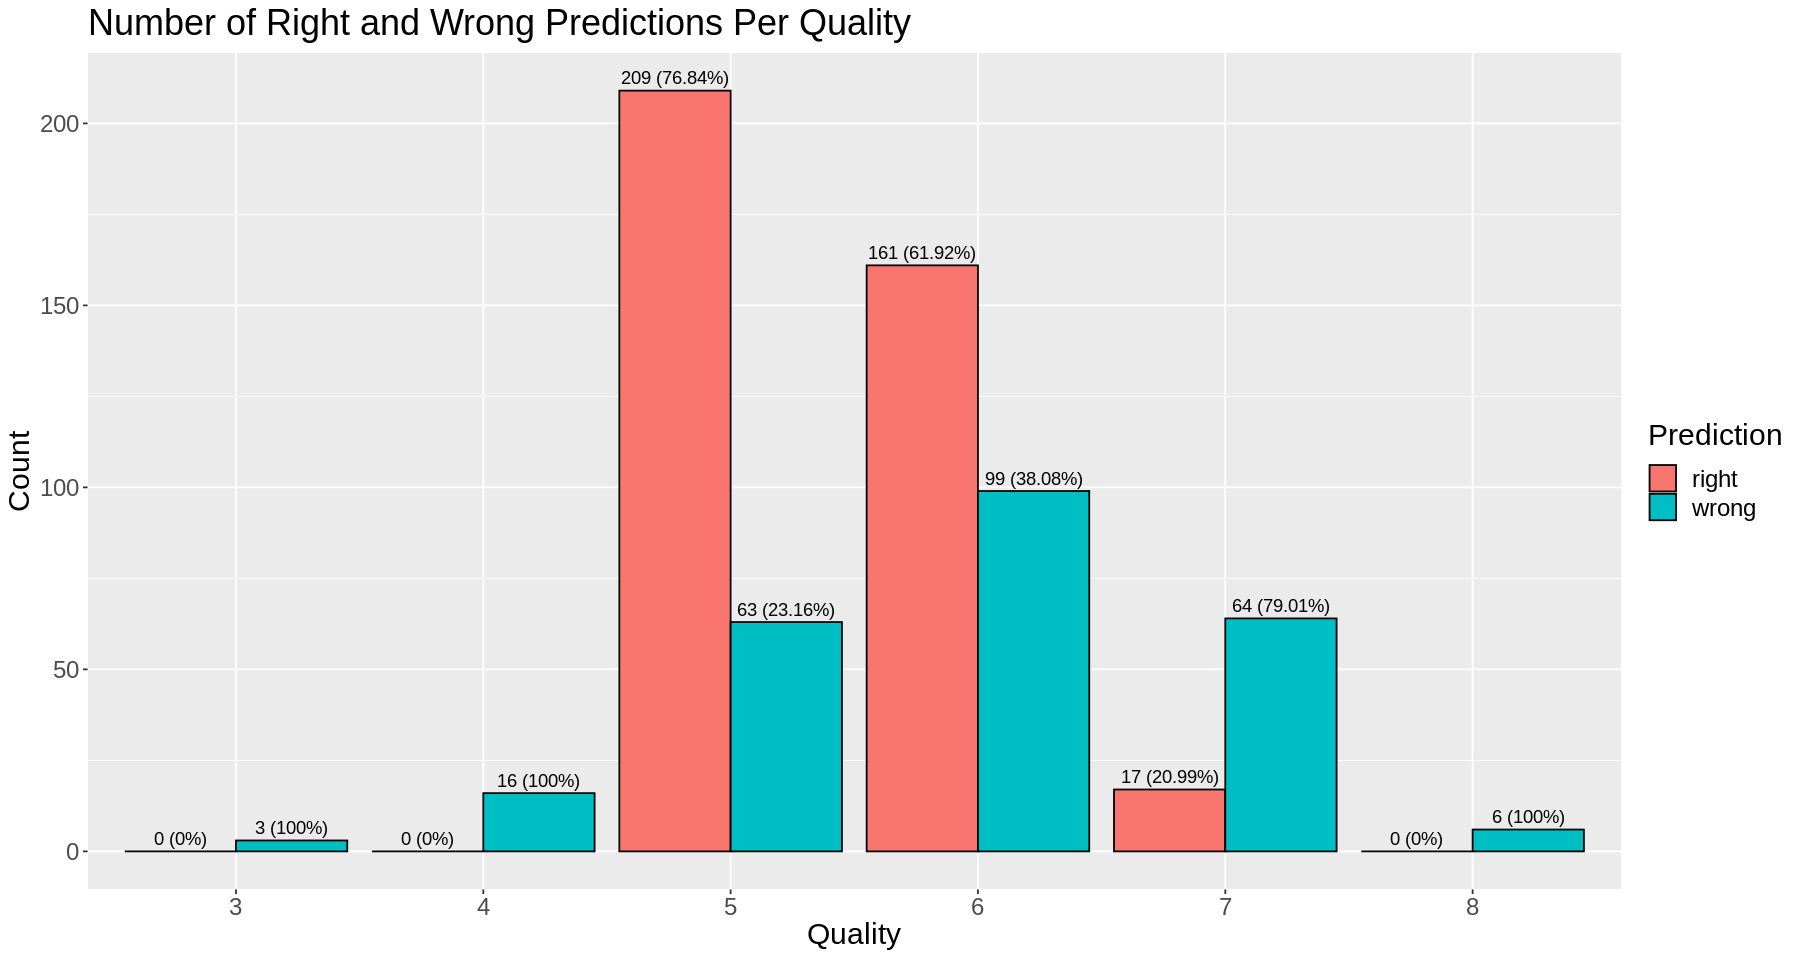

In [406]:
# produces the summarizing bar plot
options(repr.plot.width = 15, repr.plot.height = 8)
prediction_bar_plot <- prediction_summary %>%
                       pivot_longer(cols = c('right', 'wrong'),
                                    names_to = 'prediction',
                                    values_to = "count") %>%
                       ggplot(aes(x = quality, y = count, fill = prediction)) +
                       geom_col(colour = "black", position = "dodge") +
                       geom_text(aes(label = paste0(count, ' (', round(count * 100 / total_count, 2), '%)')),
                                 vjust = -0.5,
                                 position = position_dodge(width = .9)) +
                       theme(text = element_text(size = 18)) +
                       labs(title = "Number of Right and Wrong Predictions Per Quality", x = "Quality", y = "Count", fill = "Prediction")      
prediction_bar_plot

## References:

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J. (2009). Modeling wine 
	preferences by data mining from physicochemical properties. Decision 
	Support Systems. 47, 547-553. https://doi.org/10.1016/j.dss.2009.05.016.
 
Smith, D. V., & Margolskee, R. F. (2001). Making Sense of Taste. Scientific 
	American, 284, 32–39. http://www.jstor.org/stable/26059127
